# VLM for Manipulation Modelling

In [1]:
import cma
import time
import rowan
import torch
import numpy as np
import robotic as ry
import matplotlib.pyplot as plt

import mess_utils
from blackBoxKomoProblemNew import BlackBoxKomoProblem
from Robotic_Manipulation import manipulation as manip
from utils import grasping_within_komo_definition, clean_komo

In [2]:
torch.cuda.empty_cache()

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device Name: {torch.cuda.get_device_name(device)}" if device.type == "cuda" else "Using cpu")

Device Name: NVIDIA GeForce RTX 3090


## Prepare your scene

In [4]:
C = ry.Config()
C.addFile(ry.raiPath("./scenarios/push_blob.g"))
qHome = C.getJointState()

midpoint = np.array([-0.105, 0.2, 0.745])

C.addFrame("bin") \
    .setPosition(midpoint+np.array([-.22,.2,0])) \
    .setShape(ry.ST.box, size=[0.21, .36, .15]) \
    .setColor([28/255, 18/255, 210/255])

def sample_rectangular_arena(width=0.4, height=0.4, z_coord=0.745, center_point=[0, 0]):
    x = center_point[0] + np.random.uniform(-width / 2, width / 2)
    y = center_point[1] + np.random.uniform(-height / 2, height / 2)
    return [x, y, z_coord]

midpoint = sample_rectangular_arena(width=.68, height=.6, center_point=[.19, .32])

base_quat = [-1/np.sqrt(2), 1/np.sqrt(2), 0 ,0 ]
rel_quat = rowan.from_axis_angle([0,1,0], np.random.uniform(0, 2*np.pi))

C.addFrame("blob") \
    .setPosition(midpoint) \
    .setShape(ry.ST.capsule, size=[.08, .07]) \
    .setColor([106/255, 24/255, 79/255]) \
    .setQuaternion(rowan.multiply(base_quat, rel_quat))
C.view()

0

## Define your model (VLM)

In [5]:
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor

model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    torch_dtype="auto",
    device_map=device
)
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

## Take a picture of the scene

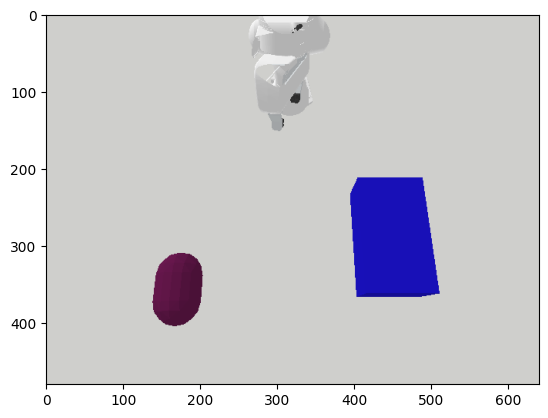

In [6]:
bot = ry.BotOp(C, False)
bot.home(C)
bot.gripperMove(ry._left)

rgb, depth = bot.getImageAndDepth("topCamera")

img_idx = 1
image_path = "./scene_image0.jpg"
plt.imsave(image_path, rgb)
plt.imshow(rgb)

## Prepare initial prompt

In [8]:
from prompting import prompt_qwen

task_description = "Put the blob in the bin."

with open("./prompts/manipulation_modelling/manip_tutorial.txt", 'r') as file:
    tutorial = file.read()

with open("./prompts/manipulation_modelling/problem_definition.txt", 'r') as file:
    problem_definition = file.read()

frame_names = [line for line in C.getFrameNames() if not line.startswith("l_")]
frame_names.append("l_gripper")
frame_names.append("l_palm")

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": tutorial,
            },
            {
                "type": "image",
                # "image": image_path,
                "image": "./example_image.jpg",
            },
            {
                "type": "text",
                "text": f"{problem_definition}{task_description}",
            },
            {
                "type": "text",
                "text": f"Here is a list of all available frames: {frame_names}",
            },
        ],
    },
]

## Loop until the problem in solved

In [ ]:
ATTEMPT_COUNT = 1
C.setJointState(qHome)
for i in range(ATTEMPT_COUNT):

    # Initial VLM prompting
    problem_definition = prompt_qwen(model, processor, device, messages)
    messages.append(mess_utils.basic_struct("system", problem_definition))
    print(problem_definition)

    # Remove junk
    # problem_definition_clean = clean_komo(problem_definition)
    # print("CLEANED VERSION", "-"*20)
    # print(problem_definition_clean)
    # print("-"*30)
    problem_definition_clean = problem_definition

    # Check if komo problem generates any errors
    komo: ry.KOMO = None
    try:
        exec(problem_definition_clean)
        ret = ry.NLP_Solver(komo.nlp(), verbose=0).solve()
        print(ret)

    except Exception as e:
        print("="*10, "ERROR", "="*10)
        print(e)
        print("="*27)
        messages.append(mess_utils.komo_error(e))
        continue
    
    if not ret.feasible:
        # Optimize komo parameters until hopefully feasible
        bbk = BlackBoxKomoProblem(C, problem_definition_clean, targets=True, verbose=3)
        
        action, observation = bbk.reset()

        options = {
        'popsize': 7,
        'maxiter': 50,
        'maxfevals': 5000,
        }
        result = cma.fmin(bbk.step, action, sigma0=.1, options=options)
        bbk.set_action(result)
        komo = bbk.build_komo(C)
        ret = ry.NLP_Solver(komo.nlp(), verbose=0).solve()

        print(ret)
        if not ret.feasible:
            messages.append(mess_utils.komo_not_feasible())
            continue

    # Visualize solution
    qs = komo.getPath()

    for q in qs:
        C.setJointState(q)
        C.view()
        time.sleep(3./len(qs))
    continue

    # Identify phases where we grasp
    switch_indices = grasping_within_komo_definition(problem_definition)

    # Execute on robot
    prev_s = 0
    for i, s in enumerate(switch_indices):
        
        # Moving
        bot.move(qs[prev_s:s], [3])
        while bot.getTimeToEnd() > 0:
            bot.sync(C)

        # Grasping
        if i % 2 == 0:
            bot.gripperClose(ry._left)
        else:
            bot.gripperMove(ry._left)
            
        prev_s = s

    # Take a picture and verify if the task was solved successfully
    rgb, depth = bot.getImageAndDepth("topCamera")

    image_path = f"./scene_image{img_idx}.jpg"
    plt.imsave(image_path, rgb)
    plt.imshow(rgb)
    plt.plot()
    img_idx += 1

    messages.append(mess_utils.confirm_image(image_path))

    image_evaluation = prompt_qwen(model, processor, device, messages)
    messages.append(mess_utils.basic_struct("system", image_evaluation))

    print(image_evaluation)
    print("-"*30)
    s = image_evaluation.strip().lower()

    if s.startswith("yes"):
        break
    else:
        messages.append(mess_utils.not_solved())

```python
M = manip.ManipulationModelling()
M.setup_pick_and_place_waypoints(C, gripper, obj, accumulated_collisions=False)
M.grasp_box(1, gripper, obj, 'l_palm')
M.target_relative_xy_position(2, obj, 'table', 'place_position')

M1 = M.sub_motion(0)
M1.retract([0, .2], gripper)
M1.keep_distance([.3, .7], 'l_palm', obj, .05)
M1.approach([.8, 1], gripper)

M2 = M.sub_motion(1)
M2.keep_distance([], 'table', 'collisionFrameCamera')
M2.keep_distance([], 'l_palm', obj)
M2.keep_distance([.2, .8], 'table', obj, .04)
```
CLEANED VERSION --------------------
M = manip.ManipulationModelling()
M.setup_pick_and_place_waypoints(C, gripper, obj, accumulated_collisions=False)
M.grasp_box(1, gripper, obj, 'l_palm')
M.target_relative_xy_position(2, obj, 'table', 'place_position')

M1 = M.sub_motion(0)
M1.retract([0, .2], gripper)
M1.keep_distance([.3, .7], 'l_palm', obj, .05)
M1.approach([.8, 1], gripper)

M2 = M.sub_motion(1)
M2.keep_distance([], 'table', 'collisionFrameCamera')
M2.keep_distance([], 'l

-- bot.cpp:~BotOp:135(0) shutting down BotOp...


: 